
0: 480x640 2 license_plates, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)


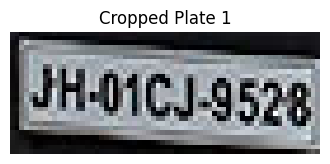

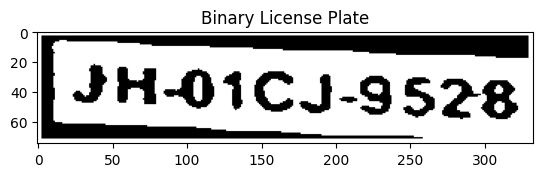

<Figure size 1500x300 with 0 Axes>

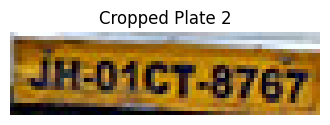

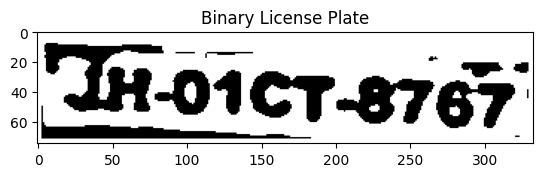

<Figure size 1500x300 with 0 Axes>

In [21]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load YOLO model
model = YOLO("C:\\Users\\ADMIN\\Desktop\\Project_ANPR\\runs\\detect\\LP_Detection_Model\\weights\\License_Plate_Detection_Model.pt")

# Load image
image_path = "Test_images\\image_15.jpg"
image = cv2.imread(image_path)

# Run inference
results = model(image)

# === Contour & Segmentation Functions ===

def find_contours(dimensions, img):
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width, upper_width, lower_height, upper_height = dimensions

    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    ii = cv2.imread('contour.jpg')  # this will be overwritten later

    x_cntr_list = []
    target_contours = []
    img_res = []

    for cntr in cntrs:
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)

            char_copy = np.zeros((44, 24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ii, (intX, intY), (intX+intWidth, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)
    
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = [img_res[idx] for idx in indices]

    return np.array(img_res_copy)

def segment_characters(image):
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH, LP_HEIGHT = img_binary_lp.shape

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title("Binary License Plate")
    plt.show()

    cv2.imwrite('contour.jpg', img_binary_lp)
    return find_contours(dimensions, img_binary_lp)

# === Process Detected Plates ===
for result in results:
    boxes = result.boxes.xyxy
    for idx, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cropped_plate = image[y1:y2, x1:x2]
        cropped_rgb = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(4, 2))
        plt.title(f"Cropped Plate {idx+1}")
        plt.imshow(cropped_rgb)
        plt.axis("off")
        plt.show()

        # Segment characters
        try:
            char_list = segment_characters(cropped_plate)
            plt.figure(figsize=(15, 3))
            for i, char_img in enumerate(char_list[:10]):
                plt.subplot(1, 10, i+1)
                plt.imshow(char_img, cmap='gray')
                plt.title(str(i+1))
                plt.axis('off')
            plt.suptitle("Segmented Characters")
            plt.show()
        except Exception as e:
            print(f"Character segmentation failed: {e}")
